In [1]:
# Import all required libraries
import re
import numpy as np
import pandas as pd
import math
import random
import tensorflow as tf
from tensorflow.keras import layers
import bert
from transformers import DistilBertTokenizer, RobertaTokenizer, TFRobertaModel,RobertaConfig
from transformers import AutoTokenizer, AutoModel, pipeline, TFDistilBertModel, DistilBertConfig
from sklearn.model_selection import train_test_split
import os

In [2]:
# Reading the data
df = pd.read_csv("clinicalnotes.csv")
df.head

<bound method NDFrame.head of      Record Id Category                                        Description  \
0          101   Yellow  Sample Name: A 5-month-old boy with cough\nDes...   
1          102   Yellow  Sample Name: Abdominal Pain - Consult\nDescrip...   
2          103   Yellow  Sample Name: Abnormal Echocardiogram\nDescript...   
3          104      Red  Sample Name: Abnormal Stress Test\nDescription...   
4          105   Yellow  Sample Name: Abrasions & Lacerations - ER Visi...   
..         ...      ...                                                ...   
511       5202     Blue  Sample Name: Well-Child Check - 7\n\nDescripti...   
512       5203     Blue  Sample Name: Well-woman checkup\n\nDescription...   
513       5204    Green  Sample Name: Worker's Compensation Injury\n\nD...   
514       5205   Yellow  Sample Name: Wound Care Consult\n\nDescription...   
515       5206   Yellow  Sample Name: Wrist Pain\n\nDescription: Consul...   

                                 

In [3]:
category_dummies = pd.get_dummies(df.Category)
new_df = pd.concat([df, category_dummies], axis=1)
new_df.head

<bound method NDFrame.head of      Record Id Category                                        Description  \
0          101   Yellow  Sample Name: A 5-month-old boy with cough\nDes...   
1          102   Yellow  Sample Name: Abdominal Pain - Consult\nDescrip...   
2          103   Yellow  Sample Name: Abnormal Echocardiogram\nDescript...   
3          104      Red  Sample Name: Abnormal Stress Test\nDescription...   
4          105   Yellow  Sample Name: Abrasions & Lacerations - ER Visi...   
..         ...      ...                                                ...   
511       5202     Blue  Sample Name: Well-Child Check - 7\n\nDescripti...   
512       5203     Blue  Sample Name: Well-woman checkup\n\nDescription...   
513       5204    Green  Sample Name: Worker's Compensation Injury\n\nD...   
514       5205   Yellow  Sample Name: Wound Care Consult\n\nDescription...   
515       5206   Yellow  Sample Name: Wrist Pain\n\nDescription: Consul...   

                                 

In [4]:
final_df = new_df[['Description', 'Blue','Green','Orange','Red','Yellow']]
# Splitting data into training and testing
train, test = train_test_split(final_df, test_size=0.2, random_state=42, shuffle=True)

In [5]:
## Function to clean the data
def clean_data(record):
    # Removing the first few header lines
    record = re.sub(r"Sample Name: .*\n", '', record)
    record = re.sub(r"Description: .*\n", '', record)
    record = re.sub(r"\(Medical Transcription Sample Report\)\n", '', record)
    # Removing additional some special characters, whitespaces and end of lines
    #record = re.sub(" \d+", " ", record)
    record = re.sub(r"[-:]+", ' ', record)
    record = re.sub(r"\n+", ' ', record)
    record = re.sub(r" +", ' ', record)
    return record

In [6]:
##### Commenting out ClinicalBert. Using DistilBERT instead
#tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
#model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
bert_to_be_used = 'distilbert-base-uncased'
#bert_to_be_used = 'roberta-base'
# Defining DistilBERT tokonizer
tokenizer = DistilBertTokenizer.from_pretrained(bert_to_be_used, do_lower_case=True, add_special_tokens=True,
                                              max_length=512, pad_to_max_length=True)
#tokenizer = RobertaTokenizer.from_pretrained(bert_to_be_used, do_lower_case=True, add_special_tokens=True,
#                                                max_length=512, pad_to_max_length=True)



In [7]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        sentence = clean_data(sentence)
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=512, pad_to_max_length=True, 
                                                 return_attention_mask=True, return_token_type_ids=True,truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        

    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [8]:
## Convert input text data into tokens
def convert_text_data(Description):
    x,y,z = tokenize(Description,tokenizer)
    return x,y

In [9]:
## Function for label data
def label_data(ds):
    Y = []
    for i in ds.index:
        #print(ds.index)
        labels = [ds.Blue[i],ds.Green[i],ds.Orange[i],ds.Red[i],ds.Yellow[i]]
        Y.append(labels)
    return np.array(Y)

In [10]:
#Preparing input data for training and testing
train_X_ids,train_X_masks = convert_text_data(train.Description)
test_X_ids,test_X_masks = convert_text_data (test.Description)

In [11]:
#Preparing label data for training and testing
train_Y = label_data(train)
test_Y = label_data(test)

In [12]:
distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

input_ids_in = tf.keras.layers.Input(shape=(512,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(512,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(512, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(5, activation='softmax')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
  layer.trainable = False
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=0.001), metrics=['accuracy'])
BASE_DIR = os.getcwd()
checkpointName = os.path.join(BASE_DIR, "model-{epoch:03d}.h5")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointName,
                                                     save_weights_only=True,
                                                     monitor='val_accuracy',
                                                     save_best_only=True,
                                                     verbose=1)
history = model.fit(
        [train_X_ids,train_X_masks],
        train_Y,
        epochs=15,
        validation_data=([test_X_ids,test_X_masks],test_Y),
        verbose=1,
        callbacks=[cp_callback])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 512, 768),)  66362880    input_token[0][0]                
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 512, 1024)    5246976     tf_distil_bert_model[0][0]       
______________________________________________________________________________________________

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, 
                             monitor='val_loss',save_best_only=True, mode='auto')

In [13]:
# Defining a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
%matplotlib inline
import matplotlib.pyplot as plt
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    pass

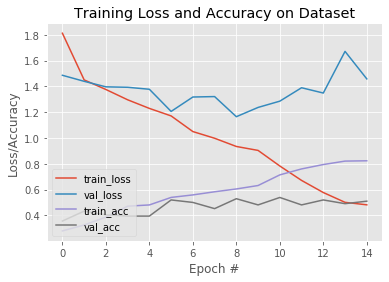

In [14]:
plot_history(history)